## 导入必要的模块

In [1]:
import pandas as pd
import sklearn
import random
import time,datetime
import requests
import scipy as sp
import sklearn.metrics as met
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as prep

from io import BytesIO
from sklearn.cluster import KMeans
from numpy.random import random_sample
from math import sqrt, log
%matplotlib inline

In [2]:
import statsmodels.api as sm

In [3]:
np.set_printoptions(precision=4, threshold=1000, linewidth=75, edgeitems=3, suppress=True)

pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 59)
pd.set_option('display.width', 75)
pd.set_option('expand_frame_repr', False)
pd.set_option('precision', 6)

## Set seed

In [4]:
seed = 42

## 导入我自定义的一些函数

In [5]:
from arsena import *

In [6]:
## some parameters:
validUserRateC = 0.95  # if a user has more than 95% missing value, then this user will be viewed as invalid

## Read data 
* data_Tab2: power data, pandas.DataFrame
* holidayData, holidayData_Part: 
* weather: outdoor air temperature (max,min)

In [3]:
data = pd.read_csv(r'.\Tianchi_power\Tianchi_power.csv',parse_dates = [0],
                   dtype = {'power_consumption': np.int16, 'user_id': np.int16},
                   #na_values =[1],
                   encoding = 'gbk')
# fill missing value with 0
data_Tab =data.pivot_table(values = 'power_consumption',index = 'record_date',
                           columns = 'user_id',fill_value = 0)
data_Tab = data_Tab.transpose()


holidayData = pd.read_csv(r'date.csv',parse_dates = [0])
#weather = pd.read_csv(r'yangzhong_weather.csv',parse_dates = [0])
weather = pd.read_csv('weather.csv',parse_dates = [0])
holidayData_Part = holidayData.iloc[:639,:]

In [72]:
weather

,﻿date,highT,lowT,skycon,Unnamed: 4
0,2015-01-01,8,-4,晴,NaN
1,2015-01-02,13,0,多云,晴
2,2015-01-03,16,3,多云,NaN
3,2015-01-04,15,4,晴,阴
4,2015-01-05,10,2,小雨,雨夹雪
5,2015-01-06,7,-1,阴,多云
6,2015-01-07,7,-2,晴,NaN
7,2015-01-08,12,-1,晴,NaN
8,2015-01-09,14,1,晴,多云
9,2015-01-10,14,1,晴,NaN


In [8]:
holidayData.head()

,date,date_type_Org,date_type,dayOfWeek
0,2015-01-01,yuandan,yuandan,4
1,2015-01-02,yuandan,yuandan,5
2,2015-01-03,yuandan,yuandan,6
3,2015-01-04,wd_Shift,wd_Shift,7
4,2015-01-05,0,0,1


In [9]:
data_Tab.to_csv('data_Tab2.csv')

## Clean Data
1. replace outliers and missing values by interpolating, but what if a user has a lot of densely distributed outliers?
   * Solution 1: delete all outliers, and replace with average value
   * Solution 2: Use a surrogagte user, which is selected from the rest users..
   
   missingValues: 1,2,Nan,or if  if a single value last for a time period longer than timeSpan, we deem it as missing value.
   outliers: checking method:

In [10]:
def missingValue_Check(timeSeries,timeSpan):
    # if a single value last for a time period longer than timeSpan, we deem it as missing value.
    missingIdx = [0]*len(timeSeries)
    i = 0
    while i < len(timeSeries)-1:
        timePeriodLength = 1
        for j in range(i+1,len(timeSeries)):
            if timeSeries[j] == timeSeries[i]:
                timePeriodLength += 1
            else:
                break
        else:
            if timePeriodLength >timeSpan:
                 missingIdx[i:] = [1]*(j-i+1)
        if timePeriodLength >timeSpan:
            missingIdx[i:j] = [1]*(j-i)
        i = j
    return missingIdx

In [11]:
timeSpan = 3
missingValue_Idx = []
for i in range(data_Tab.shape[0]):
    missingIdx = missingValue_Check(data_Tab.iloc[i,:],5)
    missingValue_Idx.append(missingIdx)
    
missingValue_Idx = pd.DataFrame(missingValue_Idx)
missingValue_Idx = missingValue_Idx.rename_axis(dict(zip(np.arange(609),data_Tab.columns)),axis = 1)
missingValue_Idx = missingValue_Idx.rename_axis(dict(zip(np.arange(1454),data_Tab.index)),axis = 0)
missingValue_Idx = missingValue_Idx.rename_axis('user_id')

In [5]:
missingValue_Idx = data_Tab<0

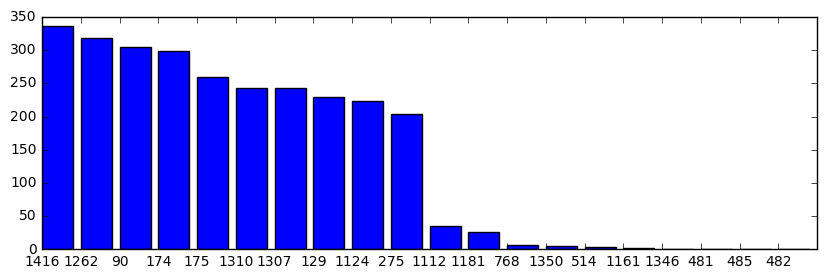

In [11]:
num_Plot = 20
plt.figure(figsize = [10,3])
ax = plt.subplot(1,1,1)
plt.bar(np.arange(num_Plot),height = list(missingValue_Idx.sum(axis = 1).sort_values(ascending = False)[:num_Plot]))
ax.set_xticks(np.arange(num_Plot))
ax.set_xticklabels(missingValue_Idx.sum(axis = 1).sort_values(ascending = False).index[:num_Plot]);

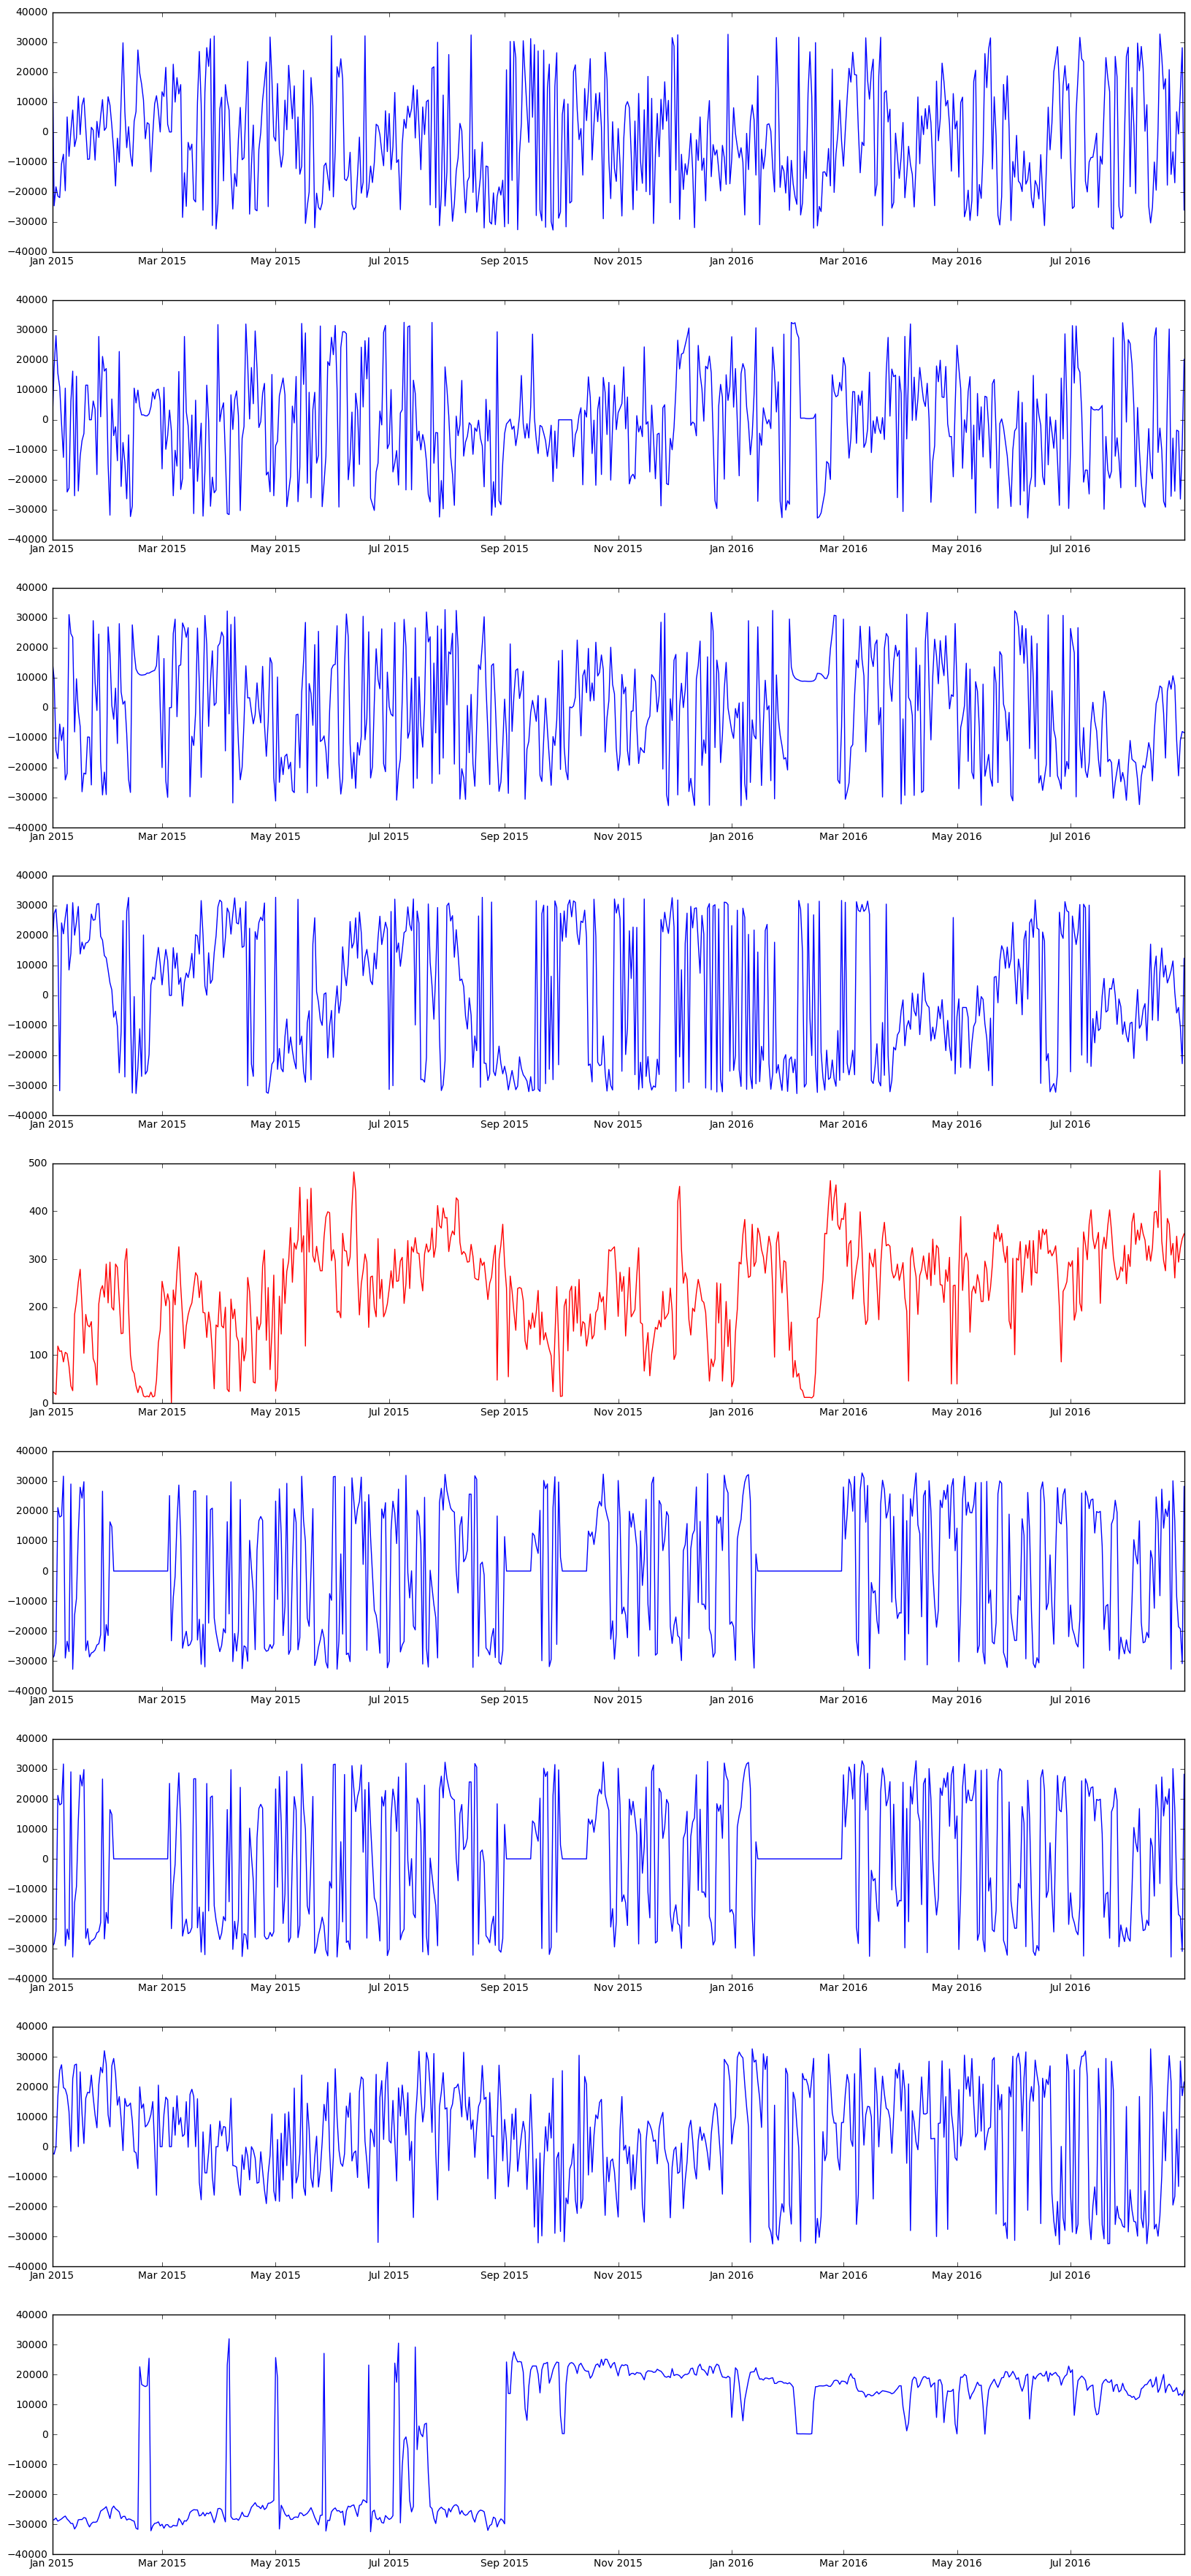

In [24]:
plt.figure(figsize = [20,50])
plt.subplot(10,1,1)
plt.plot(data_Tab.iloc[1415,:])
plt.subplot(10,1,2)
plt.plot(data_Tab.iloc[1261,:])
plt.subplot(10,1,3)
plt.plot(data_Tab.iloc[89,:])
plt.subplot(10,1,4)
plt.plot(data_Tab.iloc[173,:])
plt.subplot(10,1,5)
plt.plot(data_Tab.iloc[1,:],color = 'r')
plt.subplot(10,1,6)
plt.plot(data_Tab.iloc[1309,:])
plt.subplot(10,1,7)
plt.plot(data_Tab.iloc[1306,:])
plt.subplot(10,1,8)
plt.plot(data_Tab.iloc[128,:])
plt.subplot(10,1,9)
plt.plot(data_Tab.iloc[1123,:])

In [14]:
valid_Idx = missingValue_Idx.sum(axis = 1)<data_Tab.shape[1]*validUserRateC

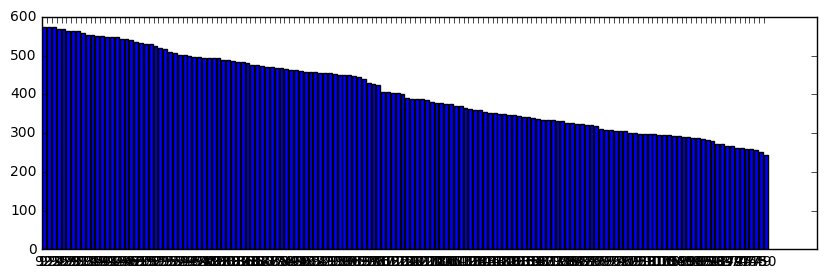

In [15]:
num_Plot = 150
plt.figure(figsize = [10,3])
ax = plt.subplot(1,1,1)
plt.bar(np.arange(num_Plot),height = list(missingValue_Idx.ix[valid_Idx,:].sum(axis = 1).sort_values(ascending = False)[:num_Plot]))
ax.set_xticks(np.arange(num_Plot))
ax.set_xticklabels(missingValue_Idx.ix[valid_Idx,:].sum(axis = 1).sort_values(ascending = False).index[::-1][:num_Plot]);

## Manually Check and correct some strange data in Users

## check outliers using 3-sigma method

In [16]:
def threeSigma(a, threshold = 3):
    ''' This function is a simple implementation of 3-sigma method
    '''
    mu = a.mean(skipna = True)
    sigma = a.std(skipna = True)
    
    diff = abs(a - mu)
    return diff > threshold * sigma

In [17]:
outlier_Count = 0
outlier_Idx = [[False]*609]*len(valid_Idx)
for i in range(data_Tab.shape[0]):
    if valid_Idx[i+1]:
        outlier = threeSigma(data_Tab.iloc[i,:],3.5)
        outlier_Idx[i] = np.array(outlier)
        if sum(outlier):
            outlier_Count += 1

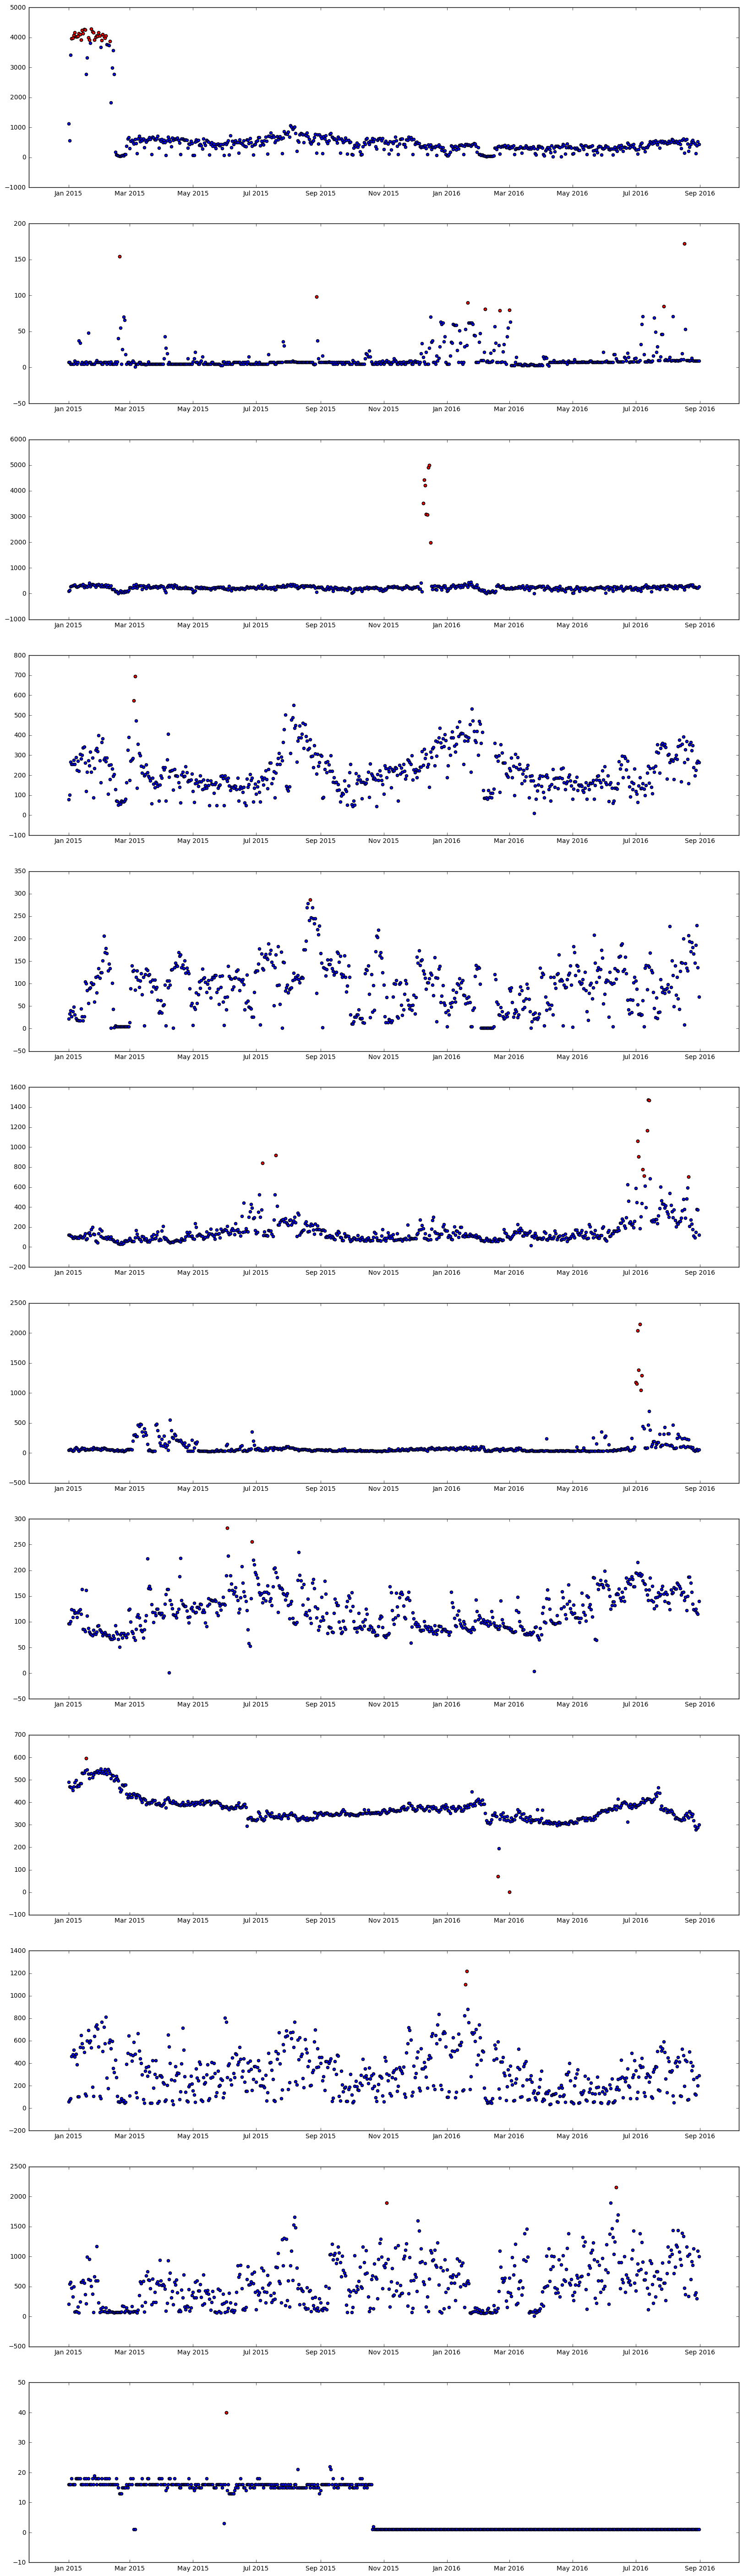

In [18]:
idxx = []
count = 0
for i,b in enumerate(valid_Idx):
    if count > 11:
        break
    if b:
        if sum(outlier_Idx[i]):
            idxx.append(i)
            count += 1   
            
list_To_Plot = idxx
plt.figure(figsize = [20,len(list_To_Plot)*6])
for i,idx in enumerate(list_To_Plot):
    plt.subplot(len(list_To_Plot),1,i+1)
    plt.scatter(data_Tab.columns,data_Tab.iloc[idx,:])
    plt.scatter(data_Tab.columns[outlier_Idx[idx]],data_Tab.ix[idx+1,outlier_Idx[idx]],c='r')

In [19]:
To_Fill_Idx = np.logical_or(pd.DataFrame(np.array(outlier_Idx)),missingValue_Idx)
To_Fill_Idx = To_Fill_Idx.rename_axis(dict(zip(np.arange(609),data_Tab.columns)),axis = 1)
To_Fill_Idx = To_Fill_Idx.rename_axis(dict(zip(np.arange(1454),data_Tab.index)),axis = 0)
To_Fill_Idx = To_Fill_Idx.rename_axis('user_id')

In [20]:
data_Filled = data_Tab.copy()
data_Filled[To_Fill_Idx] = np.float('nan')
data_Filled = data_Filled.fillna(axis = 1, method = 'bfill').fillna(axis = 1, method = 'ffill')

In [21]:
# keep the invalid value
invalid_Idx = ~valid_Idx
data_Filled.ix[invalid_Idx,:] = data_Tab.ix[invalid_Idx,:]

In [22]:
data_Filled.to_csv('data_Filled.csv')

## Clustering
    * Clustering directly, why should I implement a clustering operation?

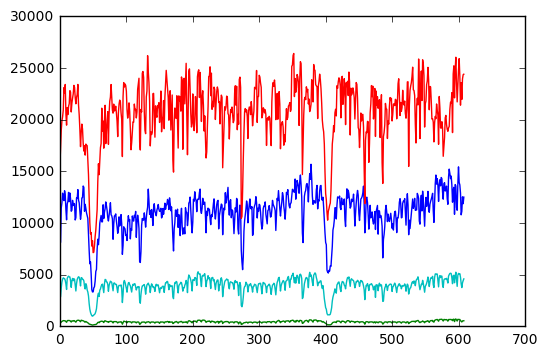

In [22]:
kmeansMiner = KMeans(n_clusters=4, random_state=4)
s = kmeansMiner.fit(data_Filled)
plt.plot(np.transpose(s.cluster_centers_));

## Distribution of output

In [34]:
sp.stats.kurtosis(data_Filled.sum())

2.8709516461993703

In [35]:
sp.stats.skew(data_Filled.sum())

-1.2420393483812402

(array([  4.,   1.,   6.,   4.,   3.,   1.,   2.,   4.,   6.,   0.,   4.,
          8.,   4.,   8.,  23.,  24.,  21.,  33.,  82.,  98.,  61.,  48.,
         40.,  33.,  35.,  13.,  19.,  12.,  10.,   2.]),
 array([  514009. ,   575305.7,   636602.4,   697899.1,   759195.8,
          820492.5,   881789.2,   943085.9,  1004382.6,  1065679.3,
         1126976. ,  1188272.7,  1249569.4,  1310866.1,  1372162.8,
         1433459.5,  1494756.2,  1556052.9,  1617349.6,  1678646.3,
         1739943. ,  1801239.7,  1862536.4,  1923833.1,  1985129.8,
         2046426.5,  2107723.2,  2169019.9,  2230316.6,  2291613.3,
         2352910. ]),
 <a list of 30 Patch objects>)

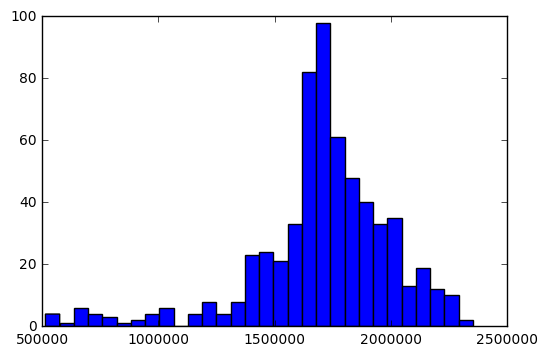

In [33]:
plt.hist(data_Filled.sum(),bins = 30)

## Predict with Facebook's prophet

In [25]:
from fbprophet import Prophet

In [26]:
holidays = holidayData.join(pd.DataFrame(np.ones([holidayData.shape[0],1])*-1,columns = ['lower_window']))\
    .join(pd.DataFrame(np.zeros([holidayData.shape[0],1]),columns = ['upper_window']))
holidays = holidays.rename(columns = {'date':'ds','date_type':'holiday'})
holidays_C = holidays.iloc[0:2,:]
for i in range(2,holidays.shape[0]):
    if holidays.holiday[i] not in '1234567':
        holidays_C = holidays_C.append(holidays.iloc[i,:])

### Develop a single model for each user

In [27]:
forecast_List = []
t1 = time.time()
for i in range(data_Filled.shape[0]):
    # Prepare trainData
    trainData = data_Filled.iloc[i,:-31]
    trainData = trainData.reset_index().rename(columns={'record_date':'ds',i+1:"y"})
    trainData.tail()
    # fit model
    m = Prophet(holidays=holidays_C,yearly_seasonality=True)
    m.fit(trainData)
    
    future = m.make_future_dataframe(periods = 31)
    
    forecast = m.predict(future)
    forecast_List.append(forecast)
    print(i,time.time()-t1)

0 4.348268270492554


KeyboardInterrupt: 

In [302]:
forecast_All2 = np.zeros(609)
for forecast in forecast_List:
    forecast_All2 += np.array(forecast.yhat)

## Develop an integral model for all user

In [28]:
data_All = data_Filled.sum()
trainData = data_All.reset_index().rename(columns={'record_date':'ds',0:"y"})

m = Prophet(holidays=holidays_C,yearly_seasonality=True)
m.fit(trainData.iloc[:609-31,:])

future = m.make_future_dataframe(periods = 31)
forecast_All = m.predict(future)

In [358]:
data_All2 = data_Tab.sum()
trainData2 = data_All2.reset_index().rename(columns={'record_date':'ds',0:"y"})

m2 = Prophet(holidays=holidays_C,yearly_seasonality=True)
m2.fit(trainData2.iloc[:609-31,:])

future = m2.make_future_dataframe(periods = 31)
forecast_All2 = m2.predict(future)

In [332]:
## iteratively constructing model
result = []
data_All2 = data_Filled.iloc[:,0:578].sum()
for i in range(31):
    trainData = data_All2.reset_index().rename(columns={'record_date':'ds',0:"y"})
    print(len(data_All2))

    m = Prophet(holidays=holidays_C,yearly_seasonality=True)
    m.fit(trainData)

    future = m.make_future_dataframe(periods = 1)
    forecast_All = m.predict(future)
    result.append(forecast_All.iloc[-1,:])
    data_All2 = data_Filled.iloc[:,0:579+i].sum()
    data_All2[-1] = forecast_All.yhat.iloc[-1]

578
579
580
581
582
583
584
585


KeyboardInterrupt: 

NameError: name 'forecast_All2' is not defined

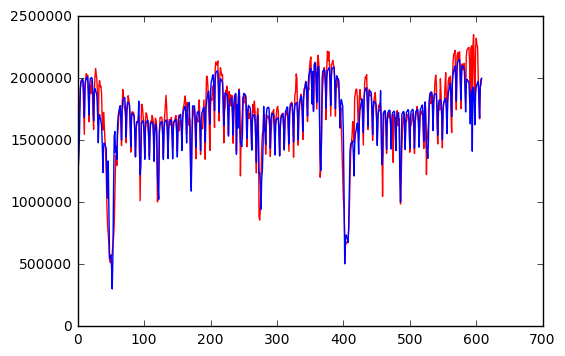

In [29]:
plt.plot(list(data_All),color = 'r')
plt.plot(list(forecast_All.yhat), color = 'b')
#plt.plot(forecast_All2[-31:],color = 'g')
plt.plot(list(forecast_All2.yhat),color = 'g')

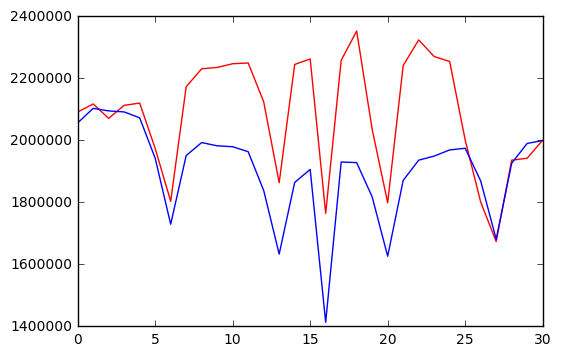

In [31]:
plt.plot(list(data_All[-31:]),color = 'r')
plt.plot(list(forecast_All.yhat[-31:]), color = 'b')
#plt.plot(forecast_All2[-31:],color = 'g')
#plt.plot(list(forecast_All2.yhat[-31:]),color = 'g')

In [34]:
forecast_All.yhat.to_csv(r'./result/prophet_Result.csv')

## result

In [44]:
data_All = data_Filled.sum()
trainData = data_All.reset_index().rename(columns={'record_date':'ds',0:"y"})

m = Prophet(holidays=holidays_C,yearly_seasonality=True)
m.fit(trainData)

future = m.make_future_dataframe(periods = 30)
forecast_All = m.predict(future)

NameError: name 'Prophet' is not defined

In [43]:
pd.Series(forecast_All.yhat[-30:].astype(int)).to_csv('result.csv')

NameError: name 'forecast_All' is not defined

In [81]:
weatherData = pd.read_csv(r'./data_Old/weather2.csv')
weatherData.skycon = weatherData.skycon.apply(foo)
weatherData.skycon = weatherData.skycon.apply(CN2EN2)

In [82]:
weatherData.skycon.to_csv(r'./data_Old/weather3.csv')

In [60]:
weatherR = weatherData.iloc[:,4].fillna('||').apply(lambda a : a.replace('|',' ').strip().split())

In [80]:
def foo(a):
    if a in ['小','中','大']:
        a = a+'雨'
    return a    
def CN2EN(a):
    codeList = {'多云':'partly_cloudy_day',
               '阴':'cloudy',
               '小雨':'xiaoyu',
               '中雨':'zhongyu',
               '大雨':'dayu',
               '晴':'clear_day',
                '阵雨':'zhenyu',
                '雷阵雨':'leizhenyu',
                '雷雨':'leiyu',
                "暴雨":'baoyu',
                '大雪':'daxue',
               '小雪':'xiaoxue',
                '雨夹雪':'yujiaxue'}
    return codeList[a]
def CN2EN2(a):
    codeList = {'多云':'partly_cloudy_day',
               '阴':'cloudy',
               '小雨':'rain',
               '中雨':'rain',
               '大雨':'rain',
               '晴':'clear_day',
                '阵雨':'rain',
                '雷阵雨':'rain',
                '雷雨':'rain',
                "暴雨":'rain',
                '大雪':'snow',
               '小雪':'snow',
                '雨夹雪':'snow'}
    return codeList[a]

In [70]:
weatherData.skycon.value_counts()

多云     257
阴      115
晴      103
小雨      48
阵雨      32
雷阵雨     31
中雨      26
大雨      10
雷雨       4
雨夹雪      4
小雪       4
暴雨       4
大雪       1
Name: skycon, dtype: int64